In [809]:
# What version of Python do you have?
%matplotlib inline
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from sklearn.metrics import confusion_matrix
from PIL import Image
from ipywidgets import IntProgress
from IPython.display import display
from operator import itemgetter
import cv2

# Check if everything alright with tensorflow
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.5.0
Keras Version: 2.5.0

Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]
Pandas 1.4.4
Scikit-Learn 1.1.2
GPU is available


# Data Pipeline
## Load data in batches

In [752]:
data = tf.keras.preprocessing.image_dataset_from_directory('data', image_size=(250,250))

Found 467 files belonging to 2 classes.


In [753]:
data_iterator = data.as_numpy_iterator()

In [756]:
batch = data_iterator.next()

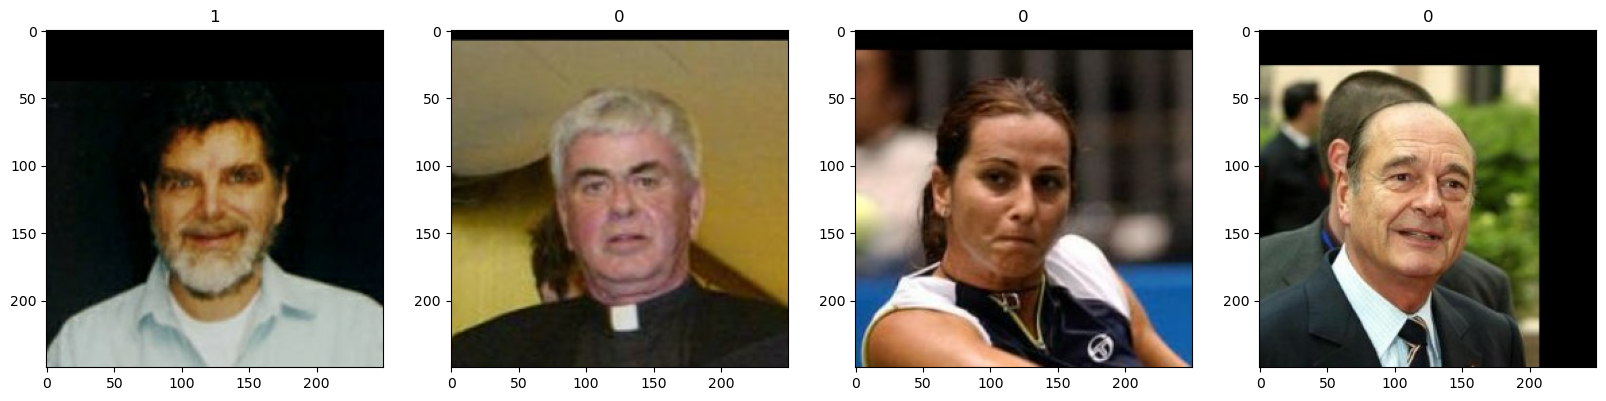

In [757]:
# Class 1 = LIKE
# Class 0 = DISLIKE
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Preproccess Data
## Scaling Images

In [758]:
data = data.map(lambda x,y: (x/255,y))

In [759]:
preprocessed_date = data.as_numpy_iterator()

In [760]:
preporcessed_batch = preprocessed_date.next()

In [761]:
print(preporcessed_batch[0].min(), preporcessed_batch[0].max())

0.0 1.0


## Partitioning the dataset

In [762]:
len(data)

15

In [767]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size =len(data) - train_size - val_size

In [768]:
print(f'train size = {train_size}, validation size = {val_size}, test size = {test_size}')

train size = 10, validation size = 4, test size = 1


In [769]:
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size+val_size).take(test_size)

# Building the model

## Loading base model

In [770]:
# Import inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [771]:
base_model = InceptionV3(input_shape = (250,250,3), # Shape of images
                                include_top = False,
                                weights = 'imagenet')

In [772]:
base_model.trainable = False

In [773]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv2d_846 (Conv2D)             (None, 124, 124, 32) 864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_846 (BatchN (None, 124, 124, 32) 96          conv2d_846[0][0]                 
__________________________________________________________________________________________________
activation_846 (Activation)     (None, 124, 124, 32) 0           batch_normalization_846[0][0]    
_______________________________________________________________________________________

## Creating labelling layer and applying to base model

In [774]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [775]:
prediction_layer = keras.layers.Dense(1, activation='sigmoid')

In [776]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [777]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [778]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
module_wrapper_10 (ModuleWra (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


## Train model

In [779]:
LOG_DIR = 'logs'

In [785]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

In [781]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)

2022-09-22 10:37:27.502667: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-09-22 10:37:27.502739: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-09-22 10:37:27.506045: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [782]:
hist = model.fit(train_data, epochs=200, validation_data=val_data, callbacks=[tensorboard_callback, earlystopping])

Epoch 1/200


2022-09-22 10:37:36.488884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/10 [==>...........................] - ETA: 1:36 - loss: 1.2406 - accuracy: 0.1562

2022-09-22 10:37:41.405376: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-09-22 10:37:41.405422: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


 2/10 [=====>........................] - ETA: 8s - loss: 1.1407 - accuracy: 0.1875  

2022-09-22 10:37:46.735332: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-22 10:37:46.736284: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-09-22 10:37:46.737366: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_09_22_10_37_46
2022-09-22 10:37:46.737991: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_09_22_10_37_46/Eduardos-MBP.trace.json.gz
2022-09-22 10:37:46.738881: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2022_09_22_10_37_46
2022-09-22 10:37:46.739267: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_09_22_10_37_46/Eduardos-MBP.memory_profile.json.gz
2022-09-22 10:37:46.740594: I t

10/10 [==============================] - ETA: 0s - loss: 0.8561 - accuracy: 0.3594

2022-09-22 10:37:48.226094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 20s 1s/step - loss: 0.8561 - accuracy: 0.3594 - val_loss: 0.7517 - val_accuracy: 0.4453
Epoch 2/200
10/10 [==============================] - 2s 187ms/step - loss: 0.6949 - accuracy: 0.5594 - val_loss: 0.6459 - val_accuracy: 0.6641
Epoch 3/200
10/10 [==============================] - 2s 189ms/step - loss: 0.6162 - accuracy: 0.6906 - val_loss: 0.5771 - val_accuracy: 0.7969
Epoch 4/200
10/10 [==============================] - 2s 183ms/step - loss: 0.6112 - accuracy: 0.7000 - val_loss: 0.5632 - val_accuracy: 0.7188
Epoch 5/200
10/10 [==============================] - 2s 185ms/step - loss: 0.5657 - accuracy: 0.7406 - val_loss: 0.6046 - val_accuracy: 0.6641
Epoch 6/200
10/10 [==============================] - 2s 188ms/step - loss: 0.5324 - accuracy: 0.7594 - val_loss: 0.5608 - val_accuracy: 0.7109
Epoch 7/200
10/10 [==============================] - 2s 181ms/step - loss: 0.5048 - accuracy: 0.7719 - val_loss: 0.5195 - val_accuracy: 0.7656
Epoch 8/200
1

## Performance

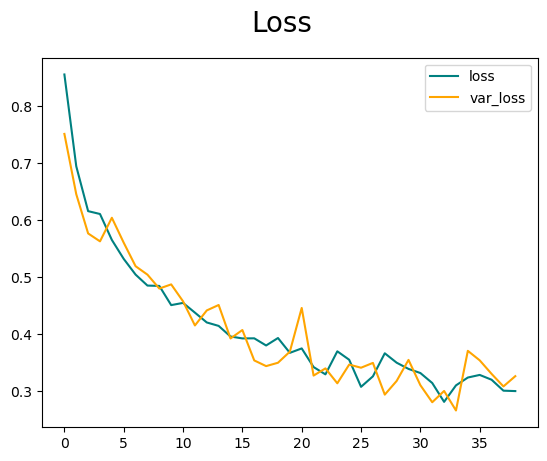

In [783]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='var_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()

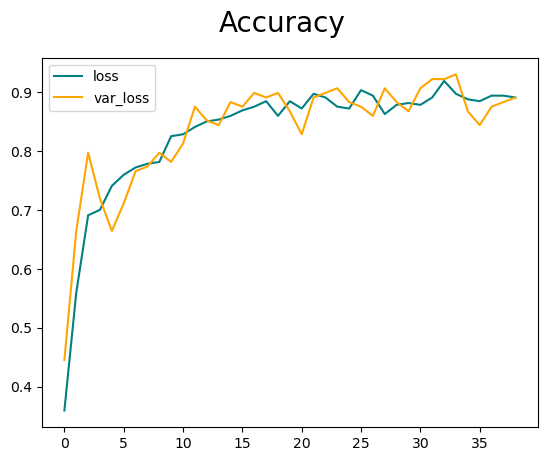

In [784]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='loss')
plt.plot(hist.history['val_accuracy'], color='orange', label='var_loss')
fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()

## Evaluate Performance

In [790]:
pre = tf.keras.metrics.Precision()
re = tf.keras.metrics.Recall()
acc = tf.keras.metrics.BinaryAccuracy()

In [791]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [808]:
precision = np.round(pre.result().numpy()*100,2)
recall = np.round(re.result().numpy()*100,2)
accuracy = np.round(acc.result().numpy()*100,2)
f1 =  np.round(2*precision*recall/(precision+recall),2)
print(f'Precision:{precision}%, Recall:{recall}%, Accuracy:{accuracy}%, F1:{f1}%')

Precision:100.0%, Recall:50.0%, Accuracy:84.21%, F1:66.67%


## Test

In [744]:
test_file = 'dua.jpeg'

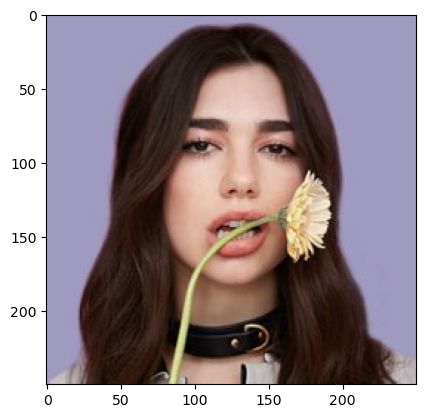

In [745]:
img = cv2.imread(test_file)
img = tf.image.resize(img, (250,250))
plt.imshow(cv2.cvtColor(img.numpy().astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.show()

In [793]:
yhat = model.predict(np.expand_dims(img/255,0))
if yhat > 0.5:
    print(f'You will LIKE this person, probability = {np.round(yhat[0][0]*100,2)}%')
else:
    print(f'You will DISLIKE this person, probability = {100-np.round(yhat[0][0]*100,2)}%')

You will DISLIKE this person, probability = 78.93%


# Recommendation

## Using the model created predict user likebility in all other users

In [794]:
LFW_DIR = 'lfw'
MAX_USERS = 10000 # TOTAL 13234
users_score = []
current_picture = 0

# Create progress bar
f = IntProgress(min=0, max=MAX_USERS)
display(f)

for directory in os.listdir(LFW_DIR):
    if directory == '.DS_Store':
            continue
    username = directory.replace('_', ' ')
    user_dict = {}
    user_dict[username] = {}
    for file_name in os.listdir(os.path.join(LFW_DIR,directory)):
        if file_name == '.DS_Store':
            f.value+=1 # Increment progress bar
            current_picture+=1
            continue
        if os.path.isfile(os.path.join('data/likes', file_name)) or os.path.isfile(os.path.join('data/dislikes', file_name)):
            f.value+=1 # Increment progress bar
            current_picture+=1
            continue
        photo_number = file_name.replace('_', ' ').replace(username,'').replace('.jpg','').replace(' ','')
        file = os.path.join(LFW_DIR,directory,file_name)
        img = cv2.imread(file)
        prediction = model.predict(np.expand_dims(img/255,0))
        user_dict[username][photo_number] = prediction[0][0]
        f.value+=1 # Increment progress bar
        current_picture+=1

    if current_picture >= MAX_USERS:
        break
            
        
    users_score.append(user_dict)

IntProgress(value=0, max=10000)

In [799]:
users_score[:100]

[{'German Khan': {'0001': 0.07607132}},
 {'Stefano Gabbana': {'0001': 0.5019121}},
 {'Dragan Covic': {'0001': 0.2429214}},
 {'Jeff Hornacek': {'0001': 0.091845445}},
 {'Sureyya Ayhan': {}},
 {'Deb Santos': {'0001': 0.04155466}},
 {'Bob Newhart': {'0001': 0.04773725}},
 {'Wang Hailan': {'0001': 0.22142182}},
 {'Paul McNulty': {'0002': 0.35160503, '0001': 0.22532083}},
 {'Jimmy Iovine': {'0001': 0.39093563}},
 {'Claudia Pechstein': {'0001': 0.12851575,
   '0003': 0.37018526,
   '0002': 0.22778763,
   '0005': 0.34726328,
   '0004': 0.3324648}},
 {'Ranil Wickremasinghe': {'0002': 0.16952866,
   '0003': 0.2187737,
   '0001': 0.28019154}},
 {'Ben Chandler': {'0001': 0.11156932}},
 {'Mark Komara': {'0001': 0.36496308}},
 {'Rand Beers': {'0001': 0.07851105}},
 {'Joanne Woodward': {'0001': 0.19485198}},
 {'John Bond': {'0001': 0.30688316}},
 {'Reginald Hudlin': {'0001': 0.24546416}},
 {'Lee Baca': {'0001': 0.27505475}},
 {'Mary-Kate Olsen': {'0002': 0.08328911,
   '0003': 0.0794299,
   '0001': 

## Sort users based on prediction to get most likeable users

In [803]:
# biggest_prediction = sum(user[username].values())/len(user[username])
# or change MAX/MIN

users_best_photo = []
for user in users_score:
    users_info = []
    username = list(user.keys())[0]
    if user[username] != {}:
        biggest_key = max(user[username], key=user[username].get)
        file_name = username.replace(' ','_')+'_'+biggest_key+'.jpg'
        users_info.append(file_name)
        biggest_prediction = user[username][biggest_key]
        users_info.append(biggest_prediction)
        users_best_photo.append(users_info)
    
users_best_photo = sorted(users_best_photo, key=itemgetter(1), reverse=True)

--------These are the users you are MOST likely to LIKE!!--------


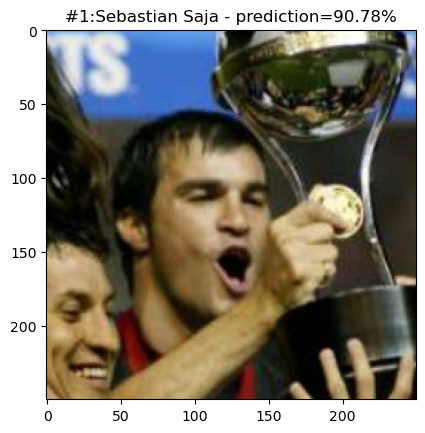

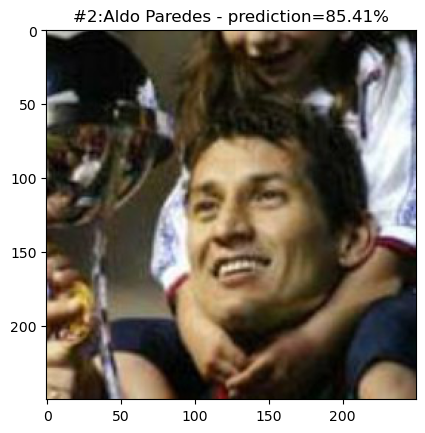

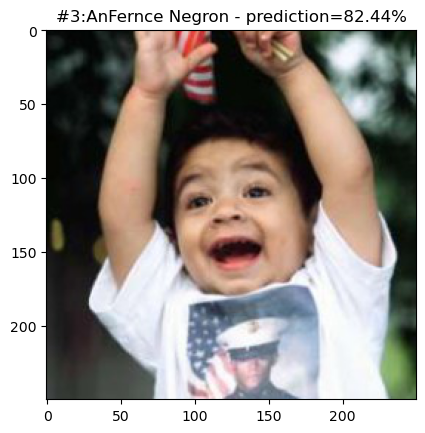

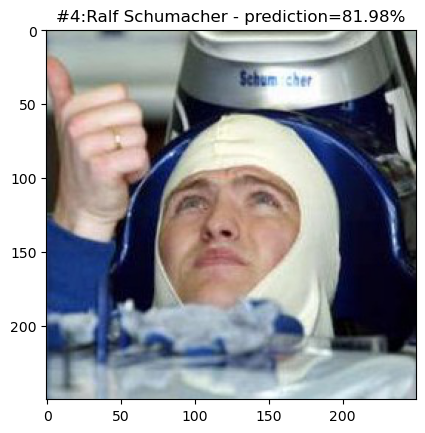

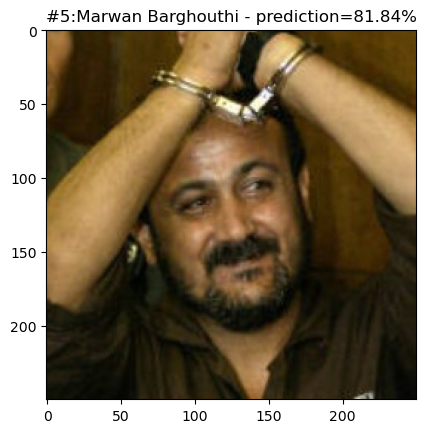

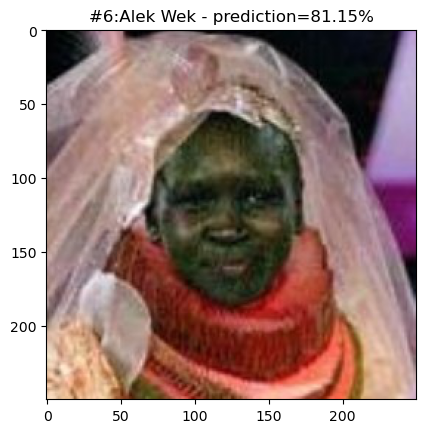

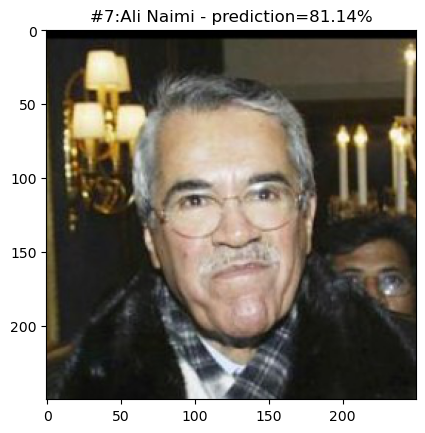

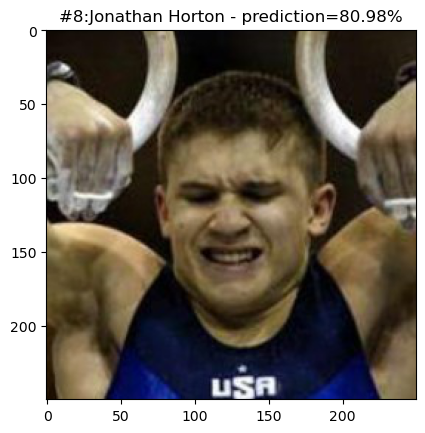

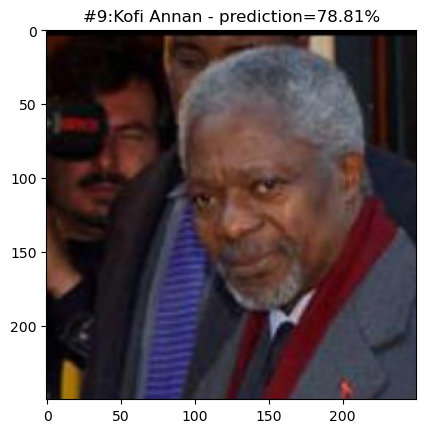

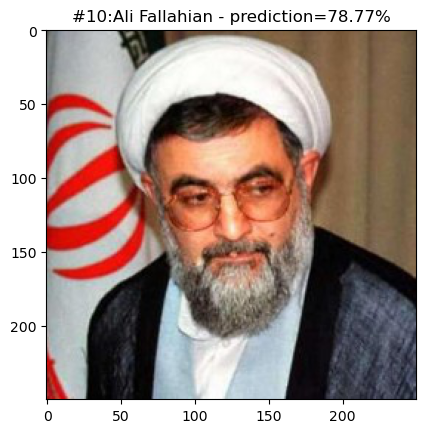

In [804]:
TOP_IMAGES = 10

print('--------These are the users you are MOST likely to LIKE!!--------')
current_image_index = 0
for user in users_best_photo:
    if current_image_index >= TOP_IMAGES:
        break
    cut_value = user[0].find('0')
    user_directory = user[0][:cut_value-1]
    username = user_directory.replace('_',' ')
    file = os.path.join(LFW_DIR,user_directory,user[0])
    img = Image.open(file)
    imgplot = plt.imshow(img)
    title = f'#{current_image_index+1}:{username} - prediction={np.round(user[1]*100,2)}%'
    plt.title(title)
    plt.show()
    current_image_index+=1

--------And these are the users you are LEAST likely to LIKE!!--------


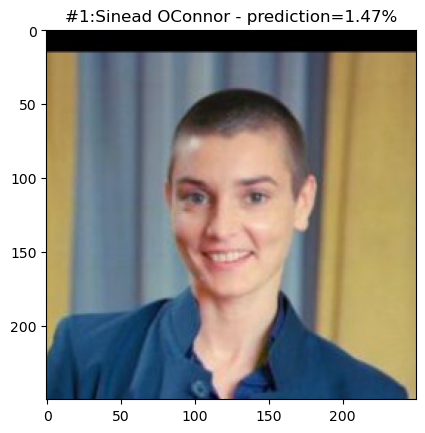

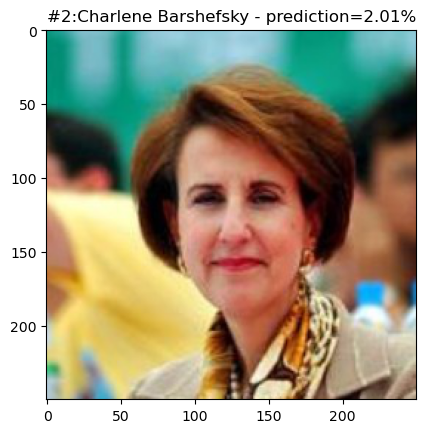

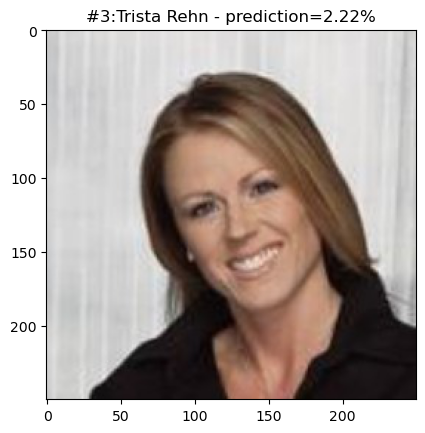

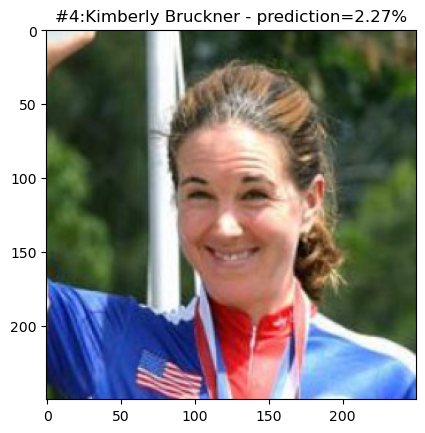

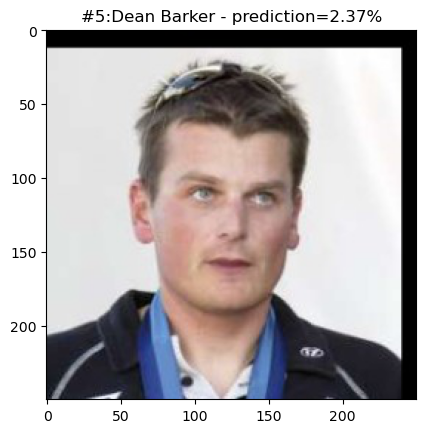

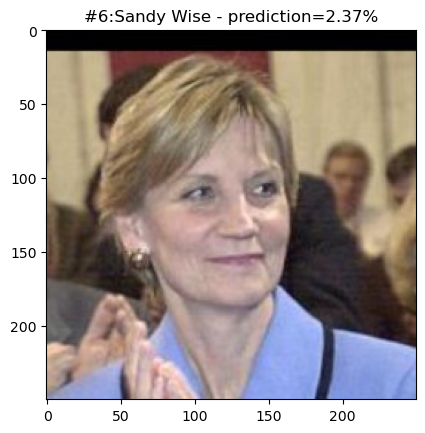

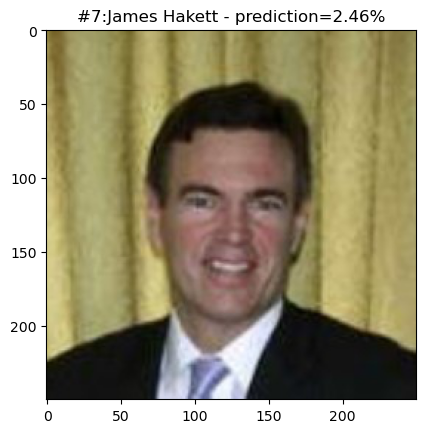

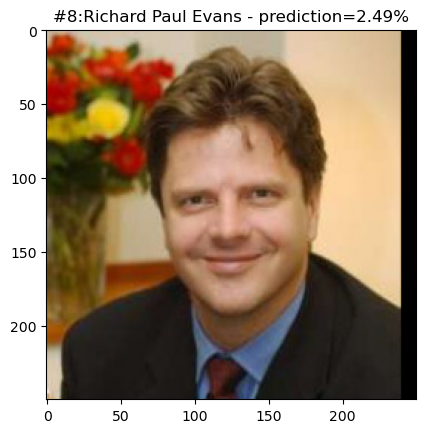

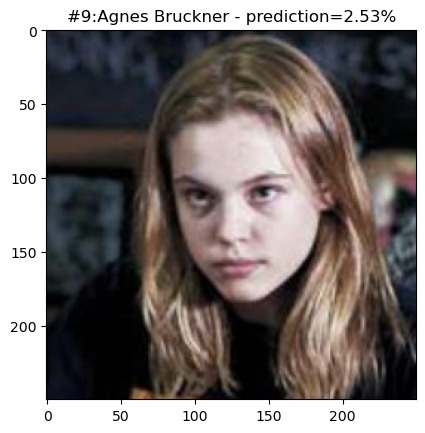

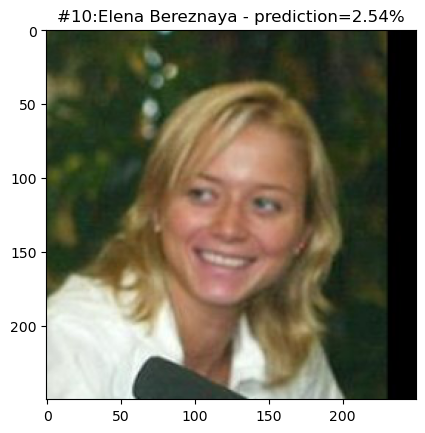

In [802]:
print('--------And these are the users you are LEAST likely to LIKE!!--------')
current_image_index = 0
for user in reversed(users_best_photo):
    if current_image_index >= TOP_IMAGES:
        break
    cut_value = user[0].find('0')
    user_directory = user[0][:cut_value-1]
    username = user_directory.replace('_',' ')
    file = os.path.join(LFW_DIR,user_directory,user[0])
    img = Image.open(file)
    imgplot = plt.imshow(img)
    title = f'#{current_image_index+1}:{username} - prediction={np.round(user[1]*100,2)}%'
    plt.title(title)
    plt.show()
    current_image_index+=1